# Logistic Regression for Spam Classification
This notebook implements a spam classifier using the SMS Spam Collection dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import urllib.request
import zipfile
import os

## Load Dataset
Downloading the SMS Spam Collection dataset from UCI Machine Learning Repository.

In [2]:
# URL for the dataset
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extract_path = "sms_spam_data"

# Download the file
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)
    print("Downloaded dataset zip.")

# Extract the file
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extracted dataset.")

# Load into Pandas DataFrame
file_path = os.path.join(extract_path, "SMSSpamCollection")
df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'])

print(f"Dataset Shape: {df.shape}")
df.head()

Downloaded dataset zip.
Extracted dataset.
Dataset Shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocessing
- Convert labels to binary (spam=1, ham=0)
- Vectorize text using TF-IDF

### Three ways to vectorize text:
- Binary: only cares whether a word appears at least once.
- Count-based: uses how many times a word appears.
- TF-IDF: weights words by how frequent they are in a document but rare across documents.

In [3]:
# Check class distribution
print(df['label'].value_counts())

# Encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Define X and Y
X = df['message']
Y = df['label']

# Split train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Vectorization (TF-IDF)
# We remove stop words to focus on meaningful content
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Vocab size: {len(tfidf.get_feature_names_out())}")

label
ham     4825
spam     747
Name: count, dtype: int64
Vocab size: 3000


## Train Logistic Regression Model

- For each training example, compute:
    - z = wx+b
    - y = 1 / (1+e^(-z))

Logistic regression uses log loss (cross-entropy), which is then used to calculate the gradient:
- L(y,y1)=−[ylog(y1)+(1−y)log(1−y1)]

In [4]:
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

print("Model training completed.")

Model training completed.


## Evaluation

- Precision: Out of all the times the model predicted positive (TP + FP), how many predictions were actually correct (TP).

- Recall: Out of all the actual positive cases (TP + FN), how many the model correctly identified (TP).

- F1 Score: A single score that balances precision (avoiding false positives) and recall (avoiding false negatives).

- Support: The total number of actual samples of a class — for the positive class, this is TP + FN.

- Accuracy: Out of all predictions made (TP + TN + FP + FN), how many were correct (TP + TN).

- Macro average: Metrics are calculated separately for each class using their own TP, TN, FP, FN, and then averaged equally — every class gets the same importance.

- Weighted average: Metrics are calculated for each class and averaged based on how many actual samples (support = TP + FN) each class has — larger classes influence the result more.

- ROC AUC: Measures how well the model separates positives from negatives by looking at how true positives increase versus false positives increase across different thresholds.

- Log loss: Evaluates how confident the model’s probability predictions are — heavily penalizes confident wrong predictions (even if TP/FP/FN/TN counts look similar).

Accuracy: 0.9785

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



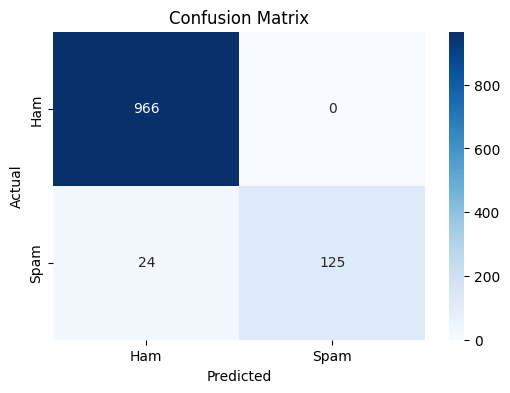

In [5]:
Y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n")
print(classification_report(Y_test, Y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Testing on Custom Messages

In [6]:
def predict_spam(text):
    text_vec = tfidf.transform([text])
    prediction = model.predict(text_vec)
    return "SPAM" if prediction[0] == 1 else "NOT SPAM"

# Test examples
print("Message 1: 'Congratulations! You won a free vacation.' ->", predict_spam("Congratulations! You won a free vacation."))
print("Message 2: 'Hey, are we still meeting for lunch?' ->", predict_spam("Hey, are we still meeting for lunch?"))

Message 1: 'Congratulations! You won a free vacation.' -> SPAM
Message 2: 'Hey, are we still meeting for lunch?' -> NOT SPAM
